In [ ]:
!ls runs

ls: cannot access 'runs': No such file or directory


In [ ]:
!pip install ultralytics "ray[tune]" roboflow torch torchvision


# https://universe.roboflow.com/nutriai/food103-2oey9/dataset/1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import libraries
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import glob
from ultralytics import YOLO
from glob import glob
import random
import numpy as np
import yaml
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.patches as patches
from pathlib import Path

from ray import tune


from torch.utils.data import DataLoader

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from ultralytics import settings

settings.update({"runs_dir": "/content/drive/MyDrive/comp4471_yolo_runs"})

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="OmP9ZUMevxKnowjaYKbn")
project = rf.workspace("nutriai").project("food103-2oey9")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FOOD103-1 in yolov8:: 100%|██████████| 14152/14152 [00:02<00:00, 7044.11it/s]


In [ ]:
base_path = dataset.location
print(base_path)
data_yaml_path = os.path.join(base_path, "data.yaml")

/content/FOOD103-1


In [ ]:
# Helper functions
def get_label_files(dataset):
    label_files = []
    for split in ["train", "valid", "test"]:
        labels_dir = os.path.join(dataset, split, "labels")
        if os.path.exists(labels_dir):
            for file in os.listdir(labels_dir):
                if file.endswith(".txt"):
                    label_files.append(os.path.join(labels_dir, file))
    return label_files


def get_class_distribution(label_files):
    class_counts = {}
    for label_file in label_files:
        with open(label_file, "r") as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1
    return class_counts


def get_class_names(dataset_path):
    # data_yaml_path = os.path.join(dataset_path, 'data.yaml')
    with open(data_yaml_path, "r") as f:
        data = yaml.safe_load(f)
    return data["names"]


def parse_label_line(line):
    parts = line.strip().split()
    class_id = int(parts[0])
    points = np.array(parts[1:], dtype=float).reshape(-1, 2)
    return class_id, points


def get_bounding_box(points):
    min_x = np.min(points[:, 0])
    min_y = np.min(points[:, 1])
    max_x = np.max(points[:, 0])
    max_y = np.max(points[:, 1])
    return min_x, min_y, max_x, max_y


def get_sample_images(dataset, num_samples=5):
    images_dir = os.path.join(dataset, "train", "images")
    if not os.path.exists(images_dir):
        return []
    image_files = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]
    samples = random.sample(image_files, min(num_samples, len(image_files)))
    return [os.path.join(images_dir, img) for img in samples]

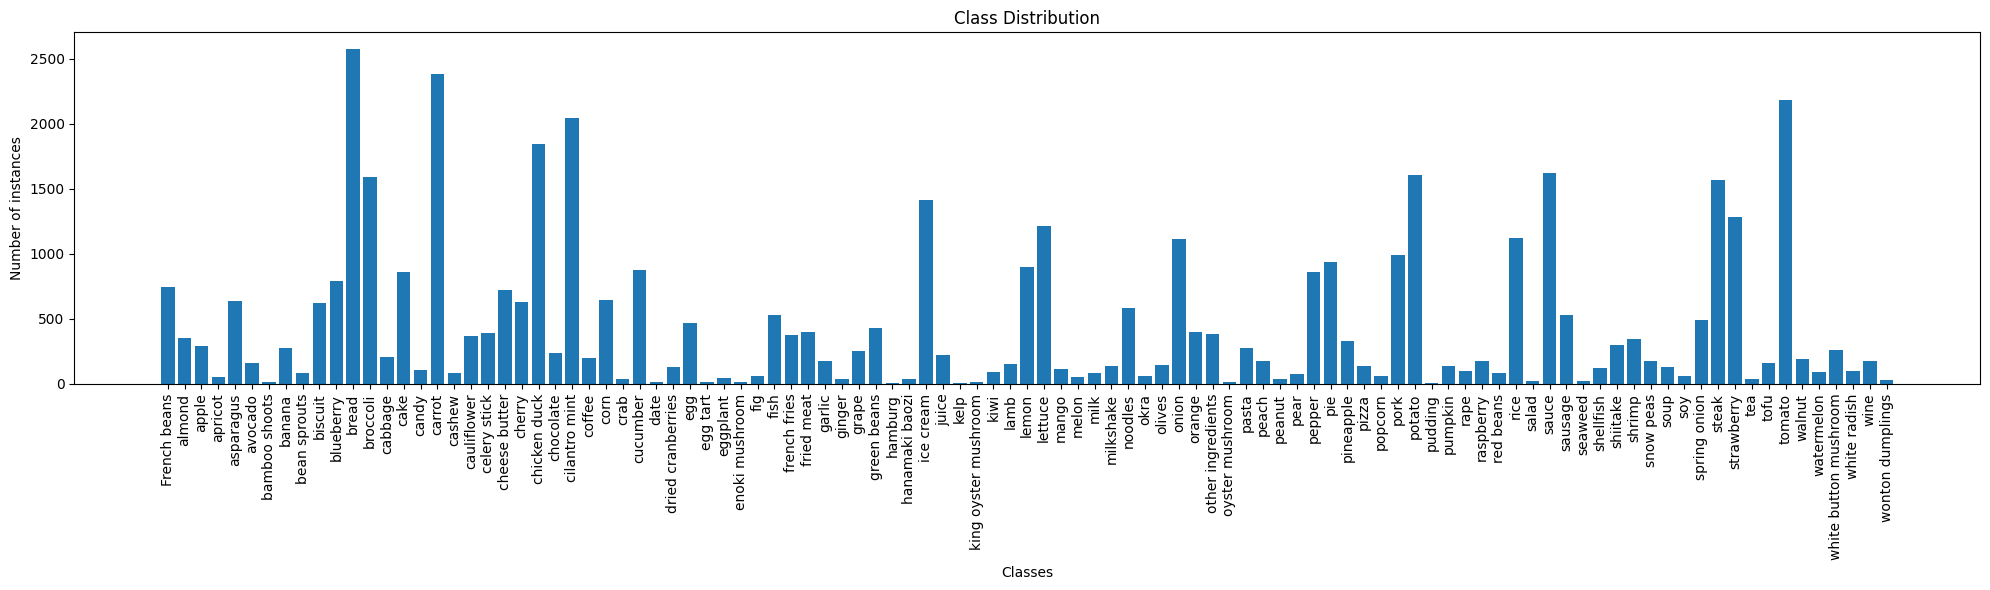

In [ ]:
def plot_class_distribution(base_path):

    # Construct the path to data.yaml
    # data_yaml_path = os.path.join(base_path, 'data.yaml')

    label_files = get_label_files(base_path)
    class_counts = get_class_distribution(label_files)
    class_names = get_class_names(base_path)

    class_ids = sorted(class_counts.keys())
    counts = [class_counts[id] for id in class_ids]
    names = [class_names[id] for id in class_ids]

    plt.figure(figsize=(20, 6))
    plt.bar(names, counts)
    plt.xlabel("Classes")
    plt.ylabel("Number of instances")
    plt.title("Class Distribution")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_class_distribution(base_path)

Processing image: /content/FOOD103-1/train/images/00004489_jpg.rf.d26330a75d54d8a91a77e8b65d1c87eb.jpg
 Label path: /content/FOOD103-1/train/labels/00004489_jpg.rf.d26330a75d54d8a91a77e8b65d1c87eb.txt
  → 3 annotations found.


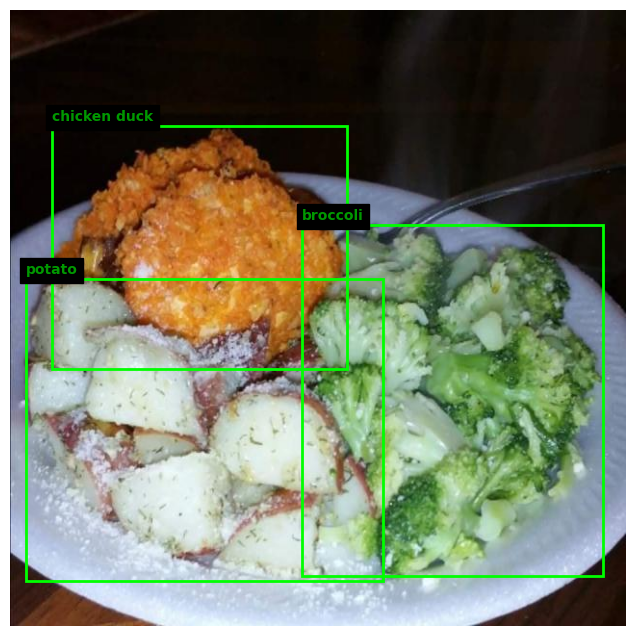

In [ ]:
def draw_sample_bounding_boxes(dataset, num_samples=5):
    base_path = Path(dataset.location)
    class_names = get_class_names(base_path)

    images_dir = base_path / "train" / "images"
    image_files = [
        f for f in images_dir.iterdir() if f.suffix.lower() in (".jpg", ".jpeg", ".png")
    ]
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    for img_path in samples:
        print(f"Processing image: {img_path}")
        # Load image
        img = plt.imread(img_path)
        h, w = img.shape[:2]

        # Locate label file
        label_path = img_path.parent.parent / "labels" / (img_path.stem + ".txt")
        print(f" Label path: {label_path}")

        if not label_path.is_file():
            print("  → No label file found, skipping.")
            continue

        # Read all lines
        with open(label_path, "r") as f:
            lines = f.readlines()
        print(f"  → {len(lines)} annotations found.")

        # Set up plot
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img)
        ax.axis("off")

        # Draw each annotation
        for line in lines:
            class_id, points = parse_label_line(line)
            # Denormalize points
            pts_px = np.array([[x * w, y * h] for x, y in points], dtype=np.float32)
            # Get bounding rect
            x, y, bw, bh = cv2.boundingRect(pts_px.astype(np.int32))
            # Draw rectangle
            rect = patches.Rectangle(
                (x, y), bw, bh, linewidth=2, edgecolor="lime", facecolor="none"
            )
            ax.add_patch(rect)
            # Draw label
            label = class_names[class_id]
            ax.text(
                x,
                y - 5,
                label,
                fontsize=10,
                color="lime",
                weight="bold",
                backgroundcolor="black",
                alpha=0.6,
            )

        plt.show()


draw_sample_bounding_boxes(dataset, 1)

In [ ]:
def hyperparameter_tuning(dataset_path, name="evolve_seg", project="runs/detect"):
    # Construct the path to the data.yaml file within the dataset directory
    data_yaml = os.path.join(dataset_path, "data.yaml")

    # Initialize the YOLO model
    model = YOLO("yolo11n-seg.pt")

    # Define the hyperparameter search space
    search_space = {
        "lr0": (1e-5, 1e-1),
        "lrf": (0.01, 1.0),
        "momentum": (0.6, 0.98),
        "weight_decay": (0.0, 0.001),
        "warmup_epochs": (0.0, 5.0),
        "warmup_momentum": (0.0, 0.95),
        "box": (0.02, 0.2),
        "cls": (0.2, 4.0),
    }

    # Perform hyperparameter tuning
    results = model.tune(
        data=data_yaml,
        epochs=10,
        iterations=20,
        optimizer="AdamW",
        space=search_space,
        plots=False,
        save=False,
        val=False,
        name=name,
        project=project,
        resume=True,
    )

    # Construct the path to the best hyperparameters file
    best_hyp_path = os.path.join(project, name, "tune", "best_hyperparameters.yaml")
    print(f"Best hyperparameters saved to: {best_hyp_path}")

    return best_hyp_path


best_hyp = hyperparameter_tuning(base_path)

In [ ]:
def train_final_model(
    data_yaml, hyp_json=None, epochs=100, save_dir="runs/segment", name="final_seg"
):
    model = YOLO("yolo11n-seg.pt")

    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=640,
        project=save_dir,
        name=name,
        # resume=True,
        device="0",
    )
    return model, results


best_hyperparams = {
    "lr0": 0.00915,
    "lrf": 0.01,
    "momentum": 0.68112,
    "weight_decay": 0.00051,
    "warmup_epochs": 2.89364,
    "warmup_momentum": 0.95,
    "box": 0.19074,
    "cls": 0.36557,
}

model, results = train_final_model(data_yaml_path, hyp_json=best_hyperparams)

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/FOOD103-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs/segment, name=final_seg, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning /content/FOOD103-1/train/labels.cache... 4951 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4951/4951 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±1.1 ms, read: 544.8±407.9 MB/s, size: 53.4 KB)


val: Scanning /content/FOOD103-1/valid/labels.cache... 1410 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1410/1410 [00:00<?, ?it/s]


Plotting labels to runs/segment/final_seg/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.3e-05, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/final_seg
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.42G      0.937       2.77      4.869      1.285         67        640: 100%|██████████| 310/310 [01:30<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]


                   all       1410       9355     0.0123     0.0263     0.0101    0.00877     0.0119     0.0255       0.01    0.00845

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       4.5G      0.863      2.206      4.435       1.22         75        640: 100%|██████████| 310/310 [01:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.75it/s]


                   all       1410       9355      0.518     0.0373     0.0268     0.0224      0.517      0.037     0.0268      0.021

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.54G     0.9221      2.073      3.829      1.255         84        640: 100%|██████████| 310/310 [01:27<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


                   all       1410       9355      0.556     0.0746     0.0475     0.0382      0.557     0.0747     0.0474     0.0362

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.56G     0.9105      2.013      3.338      1.248         66        640: 100%|██████████| 310/310 [01:26<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


                   all       1410       9355      0.596     0.0914     0.0729     0.0585      0.596     0.0914     0.0719     0.0552

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.56G     0.8729      1.933      3.049      1.223         74        640: 100%|██████████| 310/310 [01:25<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


                   all       1410       9355      0.593      0.109     0.0905     0.0733      0.593       0.11     0.0902     0.0694

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.56G     0.8515      1.908      2.884      1.209         78        640: 100%|██████████| 310/310 [01:26<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


                   all       1410       9355      0.557      0.135      0.108     0.0885      0.561      0.135      0.108     0.0842

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.58G     0.8323      1.878      2.747      1.193         78        640: 100%|██████████| 310/310 [01:27<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.57it/s]


                   all       1410       9355      0.575       0.15       0.12     0.0971      0.576      0.151       0.12     0.0927

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.58G     0.8144      1.845      2.662      1.177        109        640: 100%|██████████| 310/310 [01:25<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


                   all       1410       9355      0.633      0.147      0.129      0.106      0.631      0.148      0.129      0.101

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.58G     0.8036      1.822      2.587      1.171         68        640: 100%|██████████| 310/310 [01:25<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


                   all       1410       9355       0.62      0.158       0.14      0.113      0.616      0.157      0.139      0.107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.59G     0.8024      1.828       2.53      1.166        108        640: 100%|██████████| 310/310 [01:24<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


                   all       1410       9355      0.596      0.166      0.151      0.124      0.594      0.164       0.15      0.117

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.59G     0.7872      1.805      2.478       1.16        100        640: 100%|██████████| 310/310 [01:25<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


                   all       1410       9355      0.615      0.175      0.161      0.132      0.611      0.173       0.16      0.123

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.59G     0.7913        1.8      2.444      1.157         87        640: 100%|██████████| 310/310 [01:25<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


                   all       1410       9355      0.564      0.189      0.165      0.135      0.549      0.186      0.163      0.127

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.59G      0.783      1.782      2.377      1.148         90        640: 100%|██████████| 310/310 [01:27<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


                   all       1410       9355      0.611      0.182      0.172      0.141      0.609      0.182       0.17      0.133

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.59G     0.7715      1.758      2.323      1.146         74        640: 100%|██████████| 310/310 [01:25<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


                   all       1410       9355      0.554        0.2      0.179      0.147      0.572      0.195      0.177      0.139

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.59G     0.7692      1.733      2.293      1.137         92        640: 100%|██████████| 310/310 [01:25<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


                   all       1410       9355      0.527      0.204      0.186      0.152      0.526      0.202      0.183      0.142

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.59G     0.7696       1.76       2.28      1.139         98        640: 100%|██████████| 310/310 [01:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


                   all       1410       9355      0.567      0.205      0.191      0.157      0.569      0.202      0.188      0.147

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.59G     0.7675      1.736      2.246      1.136         74        640: 100%|██████████| 310/310 [01:29<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


                   all       1410       9355       0.52      0.212      0.192      0.158      0.523      0.209      0.191      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.59G      0.756      1.716      2.201       1.13         99        640: 100%|██████████| 310/310 [01:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.60it/s]


                   all       1410       9355      0.557      0.215      0.196      0.161      0.555      0.214      0.194      0.151

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.59G     0.7573      1.714      2.193      1.126         97        640: 100%|██████████| 310/310 [01:27<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


                   all       1410       9355      0.538      0.214      0.201      0.166      0.545      0.206      0.199      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.59G     0.7453      1.692      2.151      1.124        102        640: 100%|██████████| 310/310 [01:27<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


                   all       1410       9355      0.553      0.231      0.207      0.171      0.557      0.223      0.203      0.158

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.59G     0.7461      1.678      2.126       1.12         75        640: 100%|██████████| 310/310 [01:27<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


                   all       1410       9355      0.568      0.219      0.211      0.174      0.518      0.233      0.207      0.163

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.59G     0.7471      1.691      2.119       1.12         82        640: 100%|██████████| 310/310 [01:26<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


                   all       1410       9355      0.587      0.207      0.213      0.175      0.592      0.206      0.211      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.59G     0.7423      1.675      2.106      1.116        114        640: 100%|██████████| 310/310 [01:27<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


                   all       1410       9355      0.578      0.226      0.218       0.18      0.577      0.225      0.216      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.59G      0.746      1.679      2.087       1.12         82        640: 100%|██████████| 310/310 [01:25<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.23it/s]


                   all       1410       9355      0.528      0.242      0.221      0.182      0.526      0.239      0.218      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.59G     0.7394       1.67      2.065      1.115         67        640: 100%|██████████| 310/310 [01:26<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


                   all       1410       9355      0.548      0.234      0.221      0.183      0.546      0.232      0.217      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.59G     0.7334      1.659      2.042      1.109         91        640: 100%|██████████| 310/310 [01:27<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


                   all       1410       9355      0.527      0.245      0.225      0.186      0.526       0.24      0.222      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.59G     0.7392      1.655      2.034      1.113         61        640: 100%|██████████| 310/310 [01:26<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


                   all       1410       9355      0.523      0.253       0.23      0.189      0.533      0.251      0.228      0.177

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.59G     0.7284      1.651      2.018      1.107         56        640: 100%|██████████| 310/310 [01:25<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


                   all       1410       9355      0.522      0.254      0.229      0.189      0.524      0.249      0.226      0.177

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.59G     0.7324      1.659          2      1.108         84        640: 100%|██████████| 310/310 [01:29<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.65it/s]


                   all       1410       9355      0.527       0.24       0.23       0.19      0.522      0.243      0.227      0.178

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.59G     0.7228      1.621      1.974      1.104         72        640: 100%|██████████| 310/310 [01:29<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


                   all       1410       9355       0.54      0.242      0.237      0.198      0.542      0.243      0.235      0.184

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.59G     0.7287      1.641      1.977      1.106         93        640: 100%|██████████| 310/310 [01:29<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355      0.579      0.253      0.243        0.2      0.576      0.251       0.24      0.186

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.59G     0.7198      1.613      1.946      1.099         81        640: 100%|██████████| 310/310 [01:27<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355      0.554      0.255      0.239      0.198      0.553      0.255      0.237      0.185

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.59G       0.72      1.607      1.939        1.1         67        640: 100%|██████████| 310/310 [01:26<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


                   all       1410       9355      0.532      0.253      0.239      0.197      0.528      0.251      0.235      0.183

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.59G     0.7168      1.604      1.928      1.099         63        640: 100%|██████████| 310/310 [01:25<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


                   all       1410       9355      0.553      0.252      0.243      0.201      0.548      0.251      0.239      0.187

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.59G     0.7139      1.597      1.904      1.096         81        640: 100%|██████████| 310/310 [01:27<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.21it/s]


                   all       1410       9355      0.534      0.252      0.246      0.202      0.532      0.251      0.242      0.188

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.59G     0.7121      1.592      1.905      1.096         86        640: 100%|██████████| 310/310 [01:29<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.25it/s]


                   all       1410       9355      0.486      0.265      0.245      0.203      0.569       0.24      0.241      0.189

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.59G     0.7156      1.606      1.889      1.095         62        640: 100%|██████████| 310/310 [01:27<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.24it/s]


                   all       1410       9355      0.554      0.257      0.244      0.202      0.546      0.259      0.242      0.188

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.59G     0.7172      1.598      1.887      1.095         90        640: 100%|██████████| 310/310 [01:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


                   all       1410       9355      0.547      0.257      0.251      0.208      0.548      0.255      0.248      0.194

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.59G     0.7106      1.592       1.87      1.093        105        640: 100%|██████████| 310/310 [01:34<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


                   all       1410       9355      0.548      0.258      0.255      0.211      0.553      0.258      0.253      0.196

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.59G     0.7111      1.593      1.866      1.092        120        640: 100%|██████████| 310/310 [01:31<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


                   all       1410       9355      0.522      0.263      0.252      0.208       0.52      0.261      0.248      0.194

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.59G     0.7062       1.57      1.869      1.091         83        640: 100%|██████████| 310/310 [01:31<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.22it/s]


                   all       1410       9355        0.5      0.277      0.257      0.211      0.509      0.271      0.252      0.197

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.59G     0.7064      1.564      1.842      1.088        110        640: 100%|██████████| 310/310 [01:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.07it/s]


                   all       1410       9355      0.538      0.263       0.26      0.215      0.545      0.263      0.257      0.202

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.59G      0.704      1.561      1.837      1.086         82        640: 100%|██████████| 310/310 [01:34<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


                   all       1410       9355      0.479      0.274      0.256      0.212      0.489      0.272      0.252      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.59G     0.6991      1.553      1.816      1.083         65        640: 100%|██████████| 310/310 [01:27<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


                   all       1410       9355      0.516      0.268      0.255      0.211      0.524      0.262      0.252      0.197

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.59G     0.7038      1.562      1.813      1.086        121        640: 100%|██████████| 310/310 [01:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


                   all       1410       9355      0.495      0.267      0.254       0.21      0.495      0.266      0.251      0.195

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.59G     0.6996      1.559        1.8      1.082        122        640: 100%|██████████| 310/310 [01:30<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


                   all       1410       9355      0.518      0.273      0.255      0.211      0.514      0.272      0.252      0.196

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.59G      0.696      1.551      1.791      1.085         76        640: 100%|██████████| 310/310 [01:31<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


                   all       1410       9355      0.468      0.285      0.258      0.213      0.465      0.283      0.253      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.59G     0.6997      1.542      1.789      1.087         74        640: 100%|██████████| 310/310 [01:33<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.08it/s]


                   all       1410       9355      0.478      0.283      0.256      0.212      0.478      0.275      0.252      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.59G     0.6966      1.542      1.775      1.081         50        640: 100%|██████████| 310/310 [01:29<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


                   all       1410       9355      0.507      0.275      0.256      0.211      0.508      0.274      0.252      0.197

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.59G     0.6947      1.524      1.765      1.081         86        640: 100%|██████████| 310/310 [01:27<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


                   all       1410       9355      0.506      0.269      0.257      0.213      0.503      0.267      0.254      0.199

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.59G     0.6932       1.54      1.765      1.078         75        640: 100%|██████████| 310/310 [01:35<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.16it/s]


                   all       1410       9355      0.487      0.283      0.263      0.217      0.486      0.283       0.26      0.204

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.59G     0.6945      1.538      1.769      1.081         50        640: 100%|██████████| 310/310 [01:27<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355      0.473      0.298      0.263      0.217      0.487      0.288      0.259      0.202

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.59G     0.6913      1.526      1.747       1.08        124        640: 100%|██████████| 310/310 [01:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355      0.537      0.276      0.266       0.22      0.533      0.276      0.262      0.205

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.59G     0.6897      1.525      1.749      1.081         83        640: 100%|██████████| 310/310 [01:32<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


                   all       1410       9355      0.493      0.276      0.261      0.214      0.491      0.275      0.258      0.201

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.59G     0.6931      1.534      1.742      1.076         86        640: 100%|██████████| 310/310 [01:35<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.07it/s]


                   all       1410       9355      0.489      0.283      0.264      0.218      0.484      0.283       0.26      0.203

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.59G     0.6923      1.533      1.725      1.078         69        640: 100%|██████████| 310/310 [01:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.20it/s]


                   all       1410       9355      0.491      0.291      0.266      0.218      0.488      0.288      0.262      0.204

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.59G     0.6849      1.514      1.722      1.074         76        640: 100%|██████████| 310/310 [01:29<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


                   all       1410       9355      0.454      0.292      0.266       0.22      0.453      0.291      0.263      0.206

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.59G     0.6871      1.499      1.701      1.072         81        640: 100%|██████████| 310/310 [01:29<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.11it/s]


                   all       1410       9355      0.499      0.286       0.27      0.223      0.501      0.283      0.267      0.208

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.59G     0.6842       1.52      1.703      1.072         81        640: 100%|██████████| 310/310 [01:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


                   all       1410       9355      0.498      0.291      0.269      0.223      0.498      0.289      0.266      0.209

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.59G     0.6902      1.526      1.705      1.074         57        640: 100%|██████████| 310/310 [01:31<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355      0.492      0.286       0.27      0.224      0.488      0.282      0.268       0.21

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.59G       0.68      1.493      1.691      1.071         88        640: 100%|██████████| 310/310 [01:35<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355      0.493      0.281      0.269      0.222      0.512      0.273      0.265      0.208

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.59G     0.6781      1.495      1.696       1.07         60        640: 100%|██████████| 310/310 [01:30<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.07it/s]


                   all       1410       9355      0.502      0.285      0.272      0.224        0.5      0.282      0.269      0.211

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.59G     0.6931       1.53      1.698      1.077         81        640: 100%|██████████| 310/310 [01:30<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.09it/s]


                   all       1410       9355       0.54      0.271      0.268      0.221      0.542      0.269      0.264      0.208

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.59G     0.6804      1.496      1.682      1.068         91        640: 100%|██████████| 310/310 [01:30<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.19it/s]


                   all       1410       9355      0.499      0.274      0.269      0.221        0.5      0.272      0.264      0.207

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.59G     0.6825      1.498      1.676      1.069         90        640: 100%|██████████| 310/310 [01:29<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


                   all       1410       9355      0.474      0.291       0.27      0.224      0.481      0.283      0.267       0.21

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.59G     0.6778      1.486      1.663      1.067         63        640: 100%|██████████| 310/310 [01:31<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


                   all       1410       9355      0.519      0.284      0.273      0.226      0.521      0.282       0.27      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.59G     0.6812      1.493      1.661      1.069         78        640: 100%|██████████| 310/310 [01:34<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


                   all       1410       9355      0.479      0.294      0.275      0.227      0.487      0.291      0.271      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.59G      0.674      1.482      1.649      1.065         70        640: 100%|██████████| 310/310 [01:34<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


                   all       1410       9355      0.524      0.281      0.272      0.224      0.525      0.278      0.268      0.209

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.59G     0.6789      1.498      1.663      1.067        102        640: 100%|██████████| 310/310 [01:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


                   all       1410       9355      0.502      0.278      0.271      0.223      0.508      0.273      0.268       0.21

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.59G     0.6797      1.487      1.648       1.07         57        640: 100%|██████████| 310/310 [01:30<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.09it/s]


                   all       1410       9355      0.527      0.273      0.274      0.227      0.528      0.271      0.271      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.59G     0.6711      1.469      1.637      1.065         80        640: 100%|██████████| 310/310 [01:32<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


                   all       1410       9355      0.519      0.272      0.276      0.228      0.533      0.268      0.273      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.59G     0.6708      1.469       1.64      1.063         72        640: 100%|██████████| 310/310 [01:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


                   all       1410       9355      0.499      0.276      0.276      0.228      0.503      0.273      0.272      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.59G     0.6761       1.48      1.649      1.068         95        640: 100%|██████████| 310/310 [01:37<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


                   all       1410       9355      0.474       0.29      0.275      0.227      0.476      0.288      0.271      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.59G      0.669      1.458      1.621      1.063         98        640: 100%|██████████| 310/310 [01:31<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


                   all       1410       9355      0.487      0.289      0.275      0.227      0.486      0.286      0.272      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.59G     0.6715      1.479      1.624      1.061         83        640: 100%|██████████| 310/310 [01:32<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:22<00:00,  2.01it/s]


                   all       1410       9355      0.498      0.285      0.279      0.231      0.498      0.282      0.274      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.59G      0.668      1.465      1.615      1.061         80        640: 100%|██████████| 310/310 [01:31<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.57it/s]


                   all       1410       9355      0.516      0.279      0.279       0.23       0.52      0.276      0.275      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.59G     0.6735      1.479      1.625      1.063         53        640: 100%|██████████| 310/310 [01:32<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355      0.469      0.295      0.277      0.228      0.479      0.281      0.273      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.59G     0.6622      1.451      1.605      1.058         47        640: 100%|██████████| 310/310 [01:36<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


                   all       1410       9355       0.47      0.289      0.278      0.229      0.472      0.287      0.274      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.59G     0.6679      1.467      1.612       1.06         96        640: 100%|██████████| 310/310 [01:36<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


                   all       1410       9355      0.487      0.285      0.276      0.228      0.489      0.282      0.272      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.59G     0.6607      1.466        1.6      1.057         72        640: 100%|██████████| 310/310 [01:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.05it/s]


                   all       1410       9355      0.529      0.275      0.279       0.23      0.533      0.269      0.275      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.59G     0.6668      1.453      1.605      1.059         70        640: 100%|██████████| 310/310 [01:31<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


                   all       1410       9355      0.481      0.291      0.279      0.229      0.481      0.288      0.275      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.59G     0.6631      1.452      1.613      1.061         67        640: 100%|██████████| 310/310 [01:40<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


                   all       1410       9355      0.502      0.284      0.278      0.229      0.506       0.28      0.273      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.59G     0.6724      1.463      1.599       1.06         89        640: 100%|██████████| 310/310 [01:30<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.23it/s]


                   all       1410       9355       0.48      0.285      0.278      0.229      0.483      0.281      0.273      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.59G     0.6621      1.447      1.602      1.057         65        640: 100%|██████████| 310/310 [01:31<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


                   all       1410       9355        0.5      0.275      0.276      0.228      0.502      0.273      0.271      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.59G     0.6678      1.468      1.601      1.057        120        640: 100%|██████████| 310/310 [01:31<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


                   all       1410       9355      0.507      0.284      0.279       0.23       0.51       0.28      0.274      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.59G     0.6603       1.45      1.593      1.054         91        640: 100%|██████████| 310/310 [01:37<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


                   all       1410       9355      0.491      0.283      0.278      0.229        0.5      0.277      0.273      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.59G      0.667       1.46      1.597      1.057         80        640: 100%|██████████| 310/310 [01:32<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21<00:00,  2.05it/s]


                   all       1410       9355      0.486      0.289      0.278      0.229      0.479      0.283      0.274      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.59G     0.6645      1.446      1.579      1.058         84        640: 100%|██████████| 310/310 [01:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:22<00:00,  2.01it/s]


                   all       1410       9355      0.481      0.292      0.279      0.229      0.487      0.286      0.274      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.59G     0.6579      1.436      1.585      1.053         81        640: 100%|██████████| 310/310 [01:33<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


                   all       1410       9355      0.481       0.29      0.279      0.229      0.486      0.285      0.274      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.59G     0.6578      1.437      1.581      1.054         62        640: 100%|██████████| 310/310 [01:33<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


                   all       1410       9355      0.476      0.294      0.279       0.23       0.47      0.288      0.275      0.214
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.59G     0.6424      1.448       1.56      1.074         36        640: 100%|██████████| 310/310 [01:19<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.64it/s]


                   all       1410       9355      0.494      0.284      0.275      0.226       0.49      0.282      0.271      0.211

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.59G     0.6297      1.401      1.485      1.067         48        640: 100%|██████████| 310/310 [01:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


                   all       1410       9355      0.486      0.286      0.273      0.226      0.484      0.283       0.27       0.21

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.59G     0.6273      1.386      1.466      1.066         37        640: 100%|██████████| 310/310 [01:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


                   all       1410       9355      0.453      0.295      0.275      0.227      0.462      0.294      0.271      0.211

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.59G     0.6273      1.382      1.464      1.064         53        640: 100%|██████████| 310/310 [01:18<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


                   all       1410       9355      0.461      0.295      0.276      0.228      0.458      0.293      0.272      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.59G     0.6224      1.367      1.441       1.06         53        640: 100%|██████████| 310/310 [01:18<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


                   all       1410       9355      0.454      0.297      0.276      0.228      0.452      0.296      0.273      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.59G     0.6159      1.361      1.431      1.057         39        640: 100%|██████████| 310/310 [01:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


                   all       1410       9355      0.422      0.302      0.276      0.228       0.45      0.289      0.272      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.59G     0.6188      1.365      1.441      1.058         52        640: 100%|██████████| 310/310 [01:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


                   all       1410       9355      0.426      0.301      0.276      0.228      0.425      0.298      0.273      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.59G     0.6194      1.365      1.435      1.059         41        640: 100%|██████████| 310/310 [01:18<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


                   all       1410       9355      0.433        0.3      0.277      0.229      0.431      0.297      0.273      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.59G     0.6146      1.352      1.414      1.056         44        640: 100%|██████████| 310/310 [01:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


                   all       1410       9355      0.431        0.3      0.277      0.228       0.43      0.298      0.273      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.59G     0.6163      1.369      1.433      1.056         49        640: 100%|██████████| 310/310 [01:18<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


                   all       1410       9355      0.433      0.298      0.276      0.228      0.431      0.296      0.272      0.212

100 epochs completed in 3.016 hours.
Optimizer stripped from runs/segment/final_seg/weights/last.pt, 6.2MB
Optimizer stripped from runs/segment/final_seg/weights/best.pt, 6.2MB

Validating runs/segment/final_seg/weights/best.pt...
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,900,913 parameters, 0 gradients, 10.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:23,  1.91it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:02<01:01,  1.44s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:23<00:00,  1.90it/s]


                   all       1410       9355      0.498      0.285      0.279      0.231      0.498      0.282      0.274      0.215
          French beans         76        119      0.576      0.555      0.566      0.521      0.577      0.555      0.564      0.478
                almond         13         44      0.211      0.318       0.19      0.147      0.196      0.295      0.153      0.115
                 apple         28         42      0.313      0.381      0.229      0.183      0.316      0.381      0.228       0.18
               apricot          7         11      0.813      0.182      0.325      0.289      0.818      0.182      0.321      0.269
             asparagus         50        128      0.606      0.422      0.427       0.36      0.607      0.422      0.423      0.339
               avocado         18         29          0          0     0.0893     0.0775          0          0     0.0927     0.0555
                banana         35         56      0.597      0.554   

In [ ]:
# Modified Evaluate Model Function
def evaluate_model(model, data_yaml, split="test"):
    # Validate on specified split (e.g., 'val' or 'test')
    results = model.val(data=data_yaml, split=split)
    print(f"Metrics for {split} set:")
    print(f"mAP50-95 (Box): {results.box.map}")
    print(f"Precision (Box): {results.box.mp}")
    print(f"Recall (Box): {results.box.mr}")
    if hasattr(results, "mask"):
        print(f"mAP50-95 (Mask): {results.mask.map}")
        print(f"Precision (Mask): {results.mask.mp}")
        print(f"Recall (Mask): {results.mask.mr}")

    # Plot loss over epochs
    runs_dir = "runs/segment/final_seg3"
    try:
        # latest_run = max([d for d in os.listdir(runs_dir) if d.startswith('train')], key=lambda x: int(x.replace('train', '')))
        # loss_path = os.path.join(runs_dir, latest_run, 'results.csv')
        loss_path = os.path.join(runs_dir, "results.csv")
        if os.path.exists(loss_path):
            df = pd.read_csv(loss_path)
            plt.figure(figsize=(10, 5))
            plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
            plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
            if "train/mask_loss" in df.columns:
                plt.plot(df["epoch"], df["train/mask_loss"], label="Train Mask Loss")
                plt.plot(df["epoch"], df["val/mask_loss"], label="Val Mask Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Loss over Epochs")
            plt.show()
        else:
            print("Loss plot not found.")
    except ValueError:
        print("No training runs found in runs/segment/train.")


evaluate_model(model, data_yaml_path, split="test")  # Evaluate on test set
# evaluate_model(model, data_yaml, split='val')   # Evaluate on validation set

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,900,913 parameters, 0 gradients, 10.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 903.2±430.8 MB/s, size: 45.1 KB)


val: Scanning /content/FOOD103-1/test/labels... 709 images, 0 backgrounds, 0 corrupt: 100%|██████████| 709/709 [00:00<00:00, 982.61it/s]

val: New cache created: /content/FOOD103-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:28,  1.54it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:30,  1.40it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


                   all        709       4785      0.492      0.292      0.284      0.234      0.507      0.288      0.281      0.221
          French beans         31         56      0.407      0.446      0.399      0.343      0.414      0.446        0.4      0.331
                almond         10         36       0.37        0.5      0.386      0.285      0.338      0.444      0.319      0.211
                 apple         15         28      0.253      0.286      0.215      0.144      0.301      0.321      0.274      0.179
               apricot          3          5      0.396        0.2        0.1        0.1       0.41        0.2        0.1     0.0997
             asparagus         35         70      0.664        0.5      0.537      0.439       0.67        0.5       0.54      0.414
               avocado          5         13          1          0      0.321      0.289          1          0      0.325      0.294
         bamboo shoots          3          4          1          0   

FileNotFoundError: [Errno 2] No such file or directory: 'runs/segment/train'